In [1]:
import requests
import tarfile
import os

# 다운로드할 파일의 URL
url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"

# 파일을 저장할 로컬 파일 이름
local_filename = "images.tar.gz"

# 파일 다운로드
print("파일 다운로드 중...")
response = requests.get(url, stream=True)
with open(local_filename, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:
            f.write(chunk)
print("파일 다운로드 완료:", local_filename)

# 압축 해제
print("압축 해제 중...")
with tarfile.open(local_filename, "r:gz") as tar:
    tar.extractall()  # 현재 디렉토리에 압축 해제
print("압축 해제 완료")

# 압축 파일 삭제 (선택 사항)
os.remove(local_filename)
print("압축 파일 삭제 완료:", local_filename)

파일 다운로드 중...
파일 다운로드 완료: images.tar.gz
압축 해제 중...
압축 해제 완료
압축 파일 삭제 완료: images.tar.gz


In [2]:
!git clone https://github.com/ml4py/dataset-iiit-pet

Cloning into 'dataset-iiit-pet'...
Updating files:   8% (1559/18477)
Updating files:   9% (1663/18477)
Updating files:  10% (1848/18477)
Updating files:  11% (2033/18477)
Updating files:  12% (2218/18477)
Updating files:  13% (2403/18477)
Updating files:  14% (2587/18477)
Updating files:  15% (2772/18477)
Updating files:  15% (2922/18477)
Updating files:  16% (2957/18477)
Updating files:  17% (3142/18477)
Updating files:  18% (3326/18477)
Updating files:  19% (3511/18477)
Updating files:  20% (3696/18477)
Updating files:  21% (3881/18477)
Updating files:  22% (4065/18477)
Updating files:  23% (4250/18477)
Updating files:  23% (4394/18477)
Updating files:  24% (4435/18477)
Updating files:  25% (4620/18477)
Updating files:  26% (4805/18477)
Updating files:  27% (4989/18477)
Updating files:  28% (5174/18477)
Updating files:  29% (5359/18477)
Updating files:  30% (5544/18477)
Updating files:  31% (5728/18477)
Updating files:  31% (5846/18477)
Updating files:  32% (5913/18477)
Updating file

In [3]:
import glob
import matplotlib.pyplot as plt
from PIL import Image
import cv2

images = sorted(glob.glob('./dataset-iiit-pet/images/*.jpg'))

for temp in images:
    result = cv2.imread(temp,cv2.IMREAD_COLOR)
    cv2.imwrite(temp,result)

    if result.shape[2] == 4: #png확인
        print(temp)

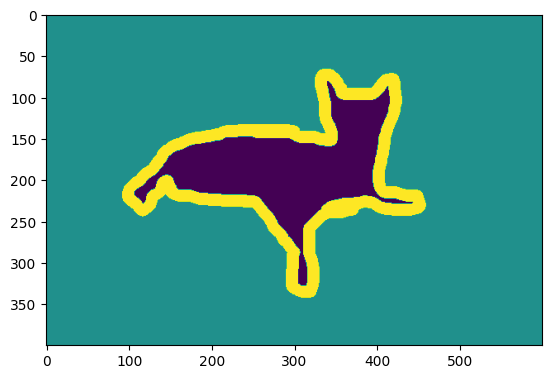

In [4]:
annotation = Image.open('./dataset-iiit-pet/annotations/trimaps/Abyssinian_1.png')
plt.imshow(annotation)

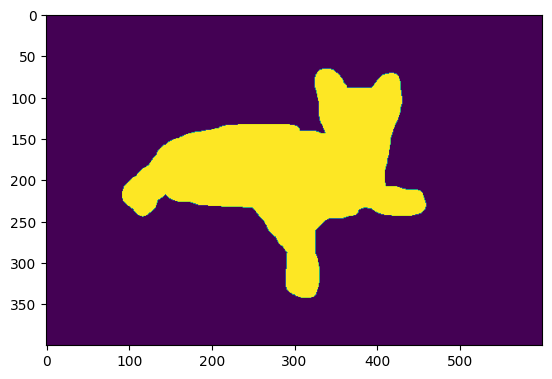

In [5]:
import numpy as np

mask = np.array(annotation).astype(np.float32)
mask[mask != 2.0] = 1.0
mask[mask == 2.0] = 0.0
plt.imshow(mask)

In [6]:
import torch
from torch.utils.data.dataset import Dataset
import torch.nn as nn

In [7]:
class Pet(Dataset):
    def __init__(self, path_to_img, path_to_anno, train=True, transforms=None, input_size=(128,128)):
        #파일을 불러와서 학습과 평가용으로 분리
        self.images = sorted(glob.glob('./dataset-iiit-pet/images/*.jpg'))
        self.annotations = sorted(glob.glob('./dataset-iiit-pet/annotations/trimaps/*.png'))

        self.X_train = self.images[:int(0.8 * len(self.images))]
        self.X_test = self.images[int(0.8 * len(self.images)) : ]
        self.y_train = self.annotations[:int(0.8 * len(self.annotations))]
        self.y_test = self.annotations[int(0.8 * len(self.annotations)) : ]

        self.train = train
        self.transforms = transforms
        self.input_size = input_size

    def __len__(self):
        if self.train:
            return len(self.X_train)
        else:
            return len(self.X_test)

    def preprocess_mask(self,mask):
        mask = mask.resize(self.input_size)
        mask = np.array(mask).astype(np.float32)
        mask[mask != 2.0] = 1.0
        mask[mask==2.0] = 0.0
        mask = torch.tensor(mask)
        return mask

    def __getitem__(self,i):
        if self.train:
            X_train = Image.open(self.X_train[i])
            X_train = self.transforms(X_train)
            y_train = Image.open(self.y_train[i])
            y_train = self.preprocess_mask(y_train)

            return X_train,y_train

        else:
            X_test = Image.open(self.X_test[i])
            X_test = self.transforms(X_test)
            y_test = Image.open(self.y_test[i])
            y_test = self.preprocess_mask(y_test)

            return X_test,y_test


In [8]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # 인코더(Encoder) 부분
        # 첫 번째 인코딩 블록: 입력 채널 3 (RGB 이미지), 출력 채널 64
        self.enc1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 풀링 레이어: 2x2 크기의 윈도우로 다운샘플링

        # 두 번째 인코딩 블록: 출력 채널 128
        self.enc2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 세 번째 인코딩 블록: 출력 채널 256
        self.enc3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 네 번째 인코딩 블록: 출력 채널 512
        self.enc4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 다섯 번째 인코딩 블록(병목층): 출력 채널 1024에서 다시 512로 줄임
        self.enc5_1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.enc5_2 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)

        # 디코더(Decoder) 부분
        # 네 번째 업샘플링 블록: 업샘플링 후 1024 채널로 연결
        self.upsample4 = nn.ConvTranspose2d(512, 512, 2, stride=2)
        self.dec4_1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.dec4_2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

        # 세 번째 업샘플링 블록: 업샘플링 후 512 채널로 연결
        self.upsample3 = nn.ConvTranspose2d(256, 256, 2, stride=2)
        self.dec3_1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec3_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

        # 두 번째 업샘플링 블록: 업샘플링 후 256 채널로 연결
        self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride=2)
        self.dec2_1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec2_2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        # 첫 번째 업샘플링 블록: 업샘플링 후 128 채널로 연결
        self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.dec1_1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dec1_3 = nn.Conv2d(64, 1, kernel_size=3, padding=1)  # 최종 출력 채널: 1 (그레이스케일 마스크)

        self.relu = nn.ReLU()  # ReLU 활성화 함수 정의

    def forward(self, x):
        # 인코더(Encoder) 부분
        x = self.enc1_1(x)
        x = self.relu(x)
        e1 = self.enc1_2(x)
        e1 = self.relu(e1)
        x = self.pool1(e1)  # 첫 번째 풀링

        x = self.enc2_1(x)
        x = self.relu(x)
        e2 = self.enc2_2(x)
        e2 = self.relu(e2)
        x = self.pool2(e2)  # 두 번째 풀링

        x = self.enc3_1(x)
        x = self.relu(x)
        e3 = self.enc3_2(x)
        e3 = self.relu(e3)
        x = self.pool3(e3)  # 세 번째 풀링

        x = self.enc4_1(x)
        x = self.relu(x)
        e4 = self.enc4_2(x)
        e4 = self.relu(e4)
        x = self.pool4(e4)  # 네 번째 풀링

        x = self.enc5_1(x)
        x = self.relu(x)
        x = self.enc5_2(x)
        x = self.relu(x)

        # 디코더(Decoder) 부분
        x = self.upsample4(x)  # 네 번째 업샘플링
        x = torch.cat([x, e4], dim=1)  # 스킵 연결 (네 번째 인코딩 출력과 연결)
        x = self.dec4_1(x)
        x = self.relu(x)
        x = self.dec4_2(x)
        x = self.relu(x)

        x = self.upsample3(x)  # 세 번째 업샘플링
        x = torch.cat([x, e3], dim=1)  # 스킵 연결 (세 번째 인코딩 출력과 연결)
        x = self.dec3_1(x)
        x = self.relu(x)
        x = self.dec3_2(x)
        x = self.relu(x)

        x = self.upsample2(x)  # 두 번째 업샘플링
        x = torch.cat([x, e2], dim=1)  # 스킵 연결 (두 번째 인코딩 출력과 연결)
        x = self.dec2_1(x)
        x = self.relu(x)
        x = self.dec2_2(x)
        x = self.relu(x)

        x = self.upsample1(x)  # 첫 번째 업샘플링
        x = torch.cat([x, e1], dim=1)  # 스킵 연결 (첫 번째 인코딩 출력과 연결)
        x = self.dec1_1(x)
        x = self.relu(x)
        x = self.dec1_2(x)
        x = self.relu(x)
        x = self.dec1_3(x)  # 최종 출력층 (마스크 출력)

        x = torch.squeeze(x)  # 차원 축소

        return x  # 최종 출력 (세그멘테이션 마스크)

In [9]:
import tqdm
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor,Resize
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [11]:
transform = Compose([
    Resize((128,128)),
    ToTensor()
])

train_set = Pet(path_to_img='./dataset-iiit-pet/images',path_to_anno='./dataset-iiit-pet/annotations/trimaps',transforms=transform,train=True)
test_set = Pet(path_to_img='./dataset-iiit-pet/images',path_to_anno='./dataset-iiit-pet/annotations/trimaps',transforms=transform,train=False)

print(len(train_set))
print(len(test_set))

5912
1478


In [12]:
train_loader = DataLoader(train_set,batch_size=32,shuffle=True)
test_loader = DataLoader(test_set)

model = UNet().to(device)

learning_rate = 0.0001

optim = Adam(params=model.parameters() , lr=learning_rate)

In [13]:
for epoch in range(200):  # 총 200번의 에폭 동안 학습 진행
    # tqdm을 사용하여 진행 상황을 표시하는 반복자(iterator) 생성
    iterator = tqdm.tqdm(train_loader)

    for data, label in iterator:  # 학습 데이터와 레이블을 배치 단위로 가져옴
        optim.zero_grad()  # 이전 배치의 그래디언트를 초기화

        preds = model(data.to(device))  # 모델에 데이터를 입력하여 예측값(preds) 계산
        loss = nn.BCEWithLogitsLoss()(  # BCEWithLogitsLoss 손실 함수 계산
            preds, label.type(torch.FloatTensor).to(device)  # 예측값과 실제 레이블을 비교
        )

        loss.backward()  # 손실에 따라 그래디언트 계산 (역전파)

        optim.step()  # 옵티마이저를 사용하여 모델의 파라미터를 업데이트

        # tqdm 진행 표시줄에 현재 에폭과 손실 값 표시
        iterator.set_description(f'epoch : {epoch+1} loss : {loss.item()}')

    torch.save(model.state_dict(), 'unet.pth')  # 매 에폭마다 모델의 가중치를 unet.pth 파일로 저장


epoch : 200 loss : 0.015967957675457: 100%|██████████| 185/185 [01:13<00:00,  2.51it/s]   


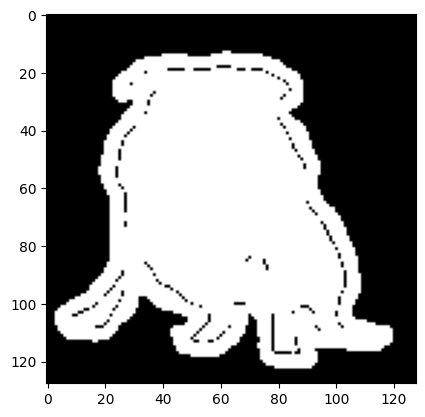

In [14]:
# 학습된 모델의 가중치를 불러옴
model.load_state_dict(torch.load('unet.pth', map_location='cpu'))  
model = model.to('cpu')  # 모델을 CPU로 이동 (추론을 CPU에서 수행)

# 테스트 세트에서 5번째 데이터와 레이블을 가져옴
data, label = test_set[5]

# 모델에 데이터를 입력하여 예측 수행
# 데이터 차원을 (1, C, H, W)로 맞추기 위해 차원 추가 (배치 차원 추가)
pred = model(torch.unsqueeze(data.to('cpu'), dim=0)) > 0.5  # 0.5를 기준으로 이진화하여 마스크 생성

with torch.no_grad():  # 추론 단계에서 불필요한 그래디언트 계산을 비활성화 (메모리 절약)
    plt.imshow(pred.squeeze().numpy(), cmap="gray")  # 예측 결과를 시각화 (2D 이미지를 표시)


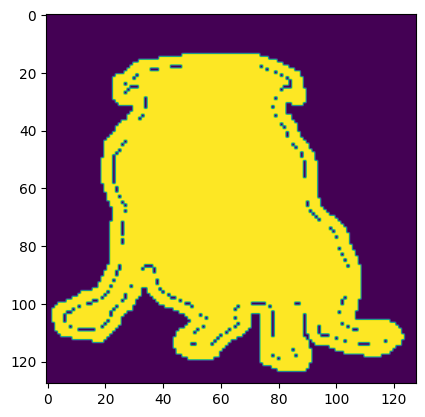

In [15]:
plt.imshow(label)